In [1]:
import sklearn
import pandas as pd
import pycaret
from dask import dataframe as dd

from src.conf import settings

In [2]:
# Read curtailment data, aggregate to dailies.
df = pd.concat(
    [
        pd.read_parquet(settings.DATA_DIR / f"processed/caiso/{y}.parquet") for y in range(2017,2020)
    ]
)
df.columns = df.columns.str.lower().str.replace(" ", "_")
df.index = df.index.tz_convert("US/Pacific")
df = df.groupby(pd.Grouper(freq="D")).sum()
# Hourly resampling is a bad idea because hour-to-hour effects are co-correlated
# df = df[columns].groupby(pd.Grouper(freq="H")).sum()
df.reset_index(inplace=True)

/home/ttu/.local/share/virtualenvs/CaReCur-b3qbtQ7S/lib/python3.7/site-packages/fastparquet/encoding.py:222: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  Numpy8 = numba.jitclass(spec8)(NumpyIO)
/home/ttu/.local/share/virtualenvs/CaReCur-b3qbtQ7S/lib/python3.7/site-packages/fastparquet/encoding.py:224: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  Numpy32 = numba.jitclass(spec32)(NumpyIO)


In [3]:
# Subset curtailments data to relevant time range
df = df[df["timestamp"].dt.month.isin(range(2,6))]

In [4]:
# Analysis Period of Dataset
df["timestamp"].describe()

count                           360
unique                          360
top       2019-05-24 00:00:00-07:00
freq                              1
first     2017-02-01 00:00:00-08:00
last      2019-05-31 00:00:00-07:00
Name: timestamp, dtype: object

In [63]:
# Label Data - based on our EDA, we might start by "guessing" a threshold of importance of .05
# Later methods will be less biased, and allow for more variance.
# TODO: Try to find natural clusterings through an unsupervised process to label the dataset, and try to predict those labels.
df["curtailment_event"] = pd.Categorical(df["solar_curtailment"]/df["solar"] > .1)

df["is_weekday"] = pd.Categorical(df["timestamp"].dt.weekday.isin([5, 6]))

In [6]:
# Merge Weather Data
# Use Day-Ahead forecasts
forecasts = [
    *(settings.DATA_DIR / f"interim/gfs/ca/gfs_3_201[7-9][01][2-5]*_0000_{i*3:03}.parquet" for i in range(5, 10))
]
dayahead_weather = dd.read_parquet(forecasts).compute()

In [7]:
dayahead_weather["timestamp"] = dayahead_weather["valid_time"].dt.tz_localize("UTC").dt.tz_convert("US/Pacific")

In [8]:
dayahead_weather.dtypes

latitude                          float64
longitude                         float64
t                                 float32
gust                              float32
tp                                float32
dswrf                             float32
uswrf                             float32
SUNSD                             float32
al                                float32
sp                                float32
csnow                             float32
cicep                             float32
cfrzr                             float32
crain                             float32
sde                               float32
surface                             int64
time                       datetime64[ns]
valid_time                 datetime64[ns]
index_right                         int64
STATEFP                            object
COUNTYFP                           object
COUNTYNS                           object
GEOID                              object
NAME                              

In [9]:
# Take an average over all datapoints (no weighting)
# FIXME: 100 We need to be more thoughtful about how to integrate this data.  
# It should be weighted somehow, or perhaps certain locations are expressed as their own IV.
# Look into Uitlity CZs
dayahead_hourly = dayahead_weather.groupby(pd.Grouper(key="timestamp", freq="H"))[["t", "dswrf", "uswrf", "gust", "SUNSD"]].mean().interpolate().reset_index()

In [10]:
dayahead_daily = dayahead_weather.groupby(pd.Grouper(key="timestamp", freq="D")).agg({"t": "mean", "dswrf": "mean", "uswrf": "mean", "SUNSD": "sum"})

In [64]:
data = df.merge(dayahead_daily, on="timestamp", how="inner")
data

,timestamp,load,solar,wind,net_load,renewables,nuclear,large_hydro,imports,generation,thermal,load_less_(generation+imports),wind_curtailment,solar_curtailment,curtailment_event,is_weekday,t,dswrf,uswrf,SUNSD
0,2017-02-01 00:00:00-08:00,7.404797e+06,6.365488e+05,8.839707e+04,6.679851e+06,1.241231e+06,652218.031425,1.058698e+06,2.043459e+06,5.361323e+06,2.409176e+06,14.109963,64.670000,8480.663464,False,False,282.630219,204.382217,46.266666,2130985.0
1,2017-02-02 00:00:00-08:00,7.367050e+06,5.002730e+05,2.195530e+05,6.647224e+06,1.235706e+06,651180.678103,1.077320e+06,1.941564e+06,5.425467e+06,2.461260e+06,19.334575,2691.564962,288.956667,False,False,282.440430,155.364441,36.537777,1721099.0
2,2017-02-03 00:00:00-08:00,7.272859e+06,5.318559e+05,2.889443e+05,6.452059e+06,1.332687e+06,650538.682373,1.103827e+06,1.913683e+06,5.359143e+06,2.272091e+06,32.670400,488.852142,869.203799,False,False,283.654236,162.995560,35.911110,1762346.0
3,2017-02-04 00:00:00-08:00,6.611103e+06,6.363877e+05,4.979092e+05,5.476806e+06,1.657910e+06,649935.253088,1.102862e+06,1.667016e+06,4.944096e+06,1.533388e+06,-9.417728,8260.820991,69858.576657,True,True,283.166656,197.639999,42.088890,1947685.0
4,2017-02-05 00:00:00-08:00,6.661248e+06,4.002112e+05,2.128107e+05,6.048226e+06,1.123362e+06,649679.457890,1.093060e+06,2.046784e+06,4.614450e+06,1.748349e+06,12.990172,0.000000,25.348000,False,True,283.199097,174.813339,35.973331,2019408.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,2019-05-27 00:00:00-07:00,5.672302e+06,7.720765e+05,1.113156e+06,3.787069e+06,2.453673e+06,656141.389061,9.970034e+05,1.169736e+06,4.502609e+06,3.957918e+05,-43.080195,18796.425323,444354.402287,True,False,292.328644,457.533325,73.480003,3091204.0
356,2019-05-28 00:00:00-07:00,6.436942e+06,1.194693e+06,9.471656e+05,4.295084e+06,2.701523e+06,656950.514763,1.010069e+06,1.417568e+06,5.019443e+06,6.509010e+05,-69.383111,924.968950,63554.570744,False,False,296.436951,507.760010,74.080002,3122509.0
357,2019-05-29 00:00:00-07:00,6.762152e+06,1.239861e+06,5.052720e+05,5.017019e+06,2.309672e+06,657307.503346,1.089729e+06,1.752092e+06,5.010103e+06,9.533939e+05,-42.688343,10658.002569,72766.329577,False,False,299.156006,511.271118,73.702225,3112164.0
358,2019-05-30 00:00:00-07:00,6.865228e+06,1.295425e+06,5.069673e+05,5.062835e+06,2.359094e+06,657488.225968,1.192374e+06,1.771105e+06,5.094174e+06,8.852177e+05,-50.745769,13743.059075,7661.455448,False,False,299.053741,506.617767,73.831108,3118246.0


In [183]:
from pycaret.classification import setup, compare_models, create_model, plot_model, tune_model, ensemble_model

data = data.dropna(subset=["t", "dswrf"])

cols = ["curtailment_event", "is_weekday", "month", "year", "t", "dswrf", "load"]

data["month"] = data["timestamp"].dt.month
data["year"] = data["timestamp"].dt.year

training_data=data[cols].sample(frac=.9, random_state=123)
training_data["curtailment_event"] = training_data["curtailment_event"].astype(int)
training_data["is_weekday"] = training_data["is_weekday"].astype(int)

test_data = data[cols].drop(training_data.index)
test_data["curtailment_event"] = training_data["curtailment_event"].astype(int)
test_data["is_weekday"] = training_data["is_weekday"].astype(int)

In [184]:
training_data.head()

,curtailment_event,is_weekday,month,year,t,dswrf,load
351,0,0,5,2019,292.234558,414.799988,6.704121e+06
79,0,0,4,2017,294.338654,483.320007,7.169724e+06
24,0,1,2,2017,279.945343,291.502228,6.521603e+06
352,0,0,5,2019,296.377899,501.662231,6.452064e+06
252,0,0,2,2019,280.735413,73.324448,7.241269e+06


In [186]:
experiment = setup(data=training_data.reset_index(drop=True), 
                   train_size=.8, target="curtailment_event", session_id=123, numeric_features=["t", "dswrf", "load"])

 
Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(319, 7)"
4,Missing Values,False
5,Numeric Features,3
6,Categorical Features,2
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [187]:
compare_models(fold=9, turbo=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Naive Bayes,0.902200,0.788700,0.222200,0.444400,0.288900,0.262100
1,K Neighbors Classifier,0.894100,0.619400,0.185200,0.314800,0.225900,0.199400
2,Logistic Regression,0.890300,0.822800,0.000000,0.000000,0.000000,0.000000
3,SVM - Linear Kernel,0.890300,0.000000,0.000000,0.000000,0.000000,0.000000
4,SVM - Radial Kernel,0.890300,0.500000,0.000000,0.000000,0.000000,0.000000
5,Ridge Classifier,0.890300,0.000000,0.000000,0.000000,0.000000,0.000000
6,Quadratic Discriminant Analysis,0.890300,0.000000,0.000000,0.000000,0.000000,0.000000
7,Linear Discriminant Analysis,0.890100,0.814600,0.259300,0.407400,0.307400,0.266000
8,Random Forest Classifier,0.886400,0.788300,0.148100,0.333300,0.200000,0.165000
9,Gaussian Process Classifier,0.886300,0.500000,0.000000,0.000000,0.000000,-0.006300


In [188]:
lr = create_model("lr")

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8846,0.8116,0.0,0.0,0.0,0.0
1,0.8846,0.8841,0.0,0.0,0.0,0.0
2,0.8846,0.8986,0.0,0.0,0.0,0.0
3,0.8846,0.8696,0.0,0.0,0.0,0.0
4,0.8846,0.7826,0.0,0.0,0.0,0.0
5,0.9200,0.9565,0.0,0.0,0.0,0.0
6,0.9200,0.6739,0.0,0.0,0.0,0.0
7,0.8800,0.6061,0.0,0.0,0.0,0.0
8,0.8800,0.9394,0.0,0.0,0.0,0.0
9,0.8800,0.7424,0.0,0.0,0.0,0.0


In [189]:
lr_bagged = ensemble_model(lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8846,0.7971,0.0,0.0,0.0,0.0
1,0.8846,0.8841,0.0,0.0,0.0,0.0
2,0.8846,0.8986,0.0,0.0,0.0,0.0
3,0.8846,0.8696,0.0,0.0,0.0,0.0
4,0.8846,0.6957,0.0,0.0,0.0,0.0
5,0.9200,0.9565,0.0,0.0,0.0,0.0
6,0.9200,0.6957,0.0,0.0,0.0,0.0
7,0.8800,0.6061,0.0,0.0,0.0,0.0
8,0.8800,0.9394,0.0,0.0,0.0,0.0
9,0.8800,0.7424,0.0,0.0,0.0,0.0


In [177]:
print(lr_bagged)

BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='auto',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=123,
                                                    solver='lbfgs', tol=0.0001,
                                                    verbose=0,
                                                    warm_start=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=10, n_jobs=None,
                  oob_score=False, random_state=123, v

In [190]:
tuned_lr = tune_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.8846,0.8116,0.0,0.0,0.0,0.0
1,0.8846,0.8841,0.0,0.0,0.0,0.0
2,0.8846,0.8986,0.0,0.0,0.0,0.0
3,0.8846,0.8696,0.0,0.0,0.0,0.0
4,0.8846,0.7826,0.0,0.0,0.0,0.0
5,0.9200,0.9565,0.0,0.0,0.0,0.0
6,0.9200,0.6739,0.0,0.0,0.0,0.0
7,0.8800,0.6061,0.0,0.0,0.0,0.0
8,0.8800,0.9394,0.0,0.0,0.0,0.0
9,0.8800,0.7424,0.0,0.0,0.0,0.0


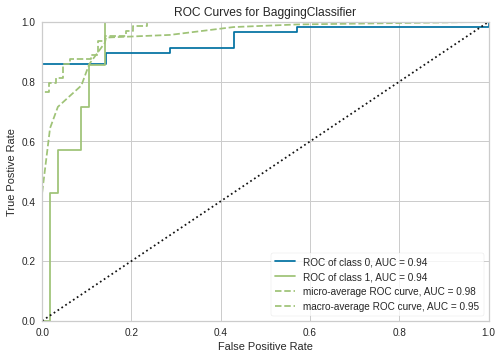

In [191]:
plot_model(lr_bagged, plot = 'auc')

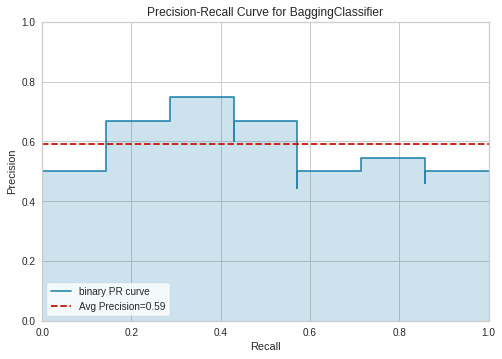

In [192]:
plot_model(lr_bagged, plot = 'pr')

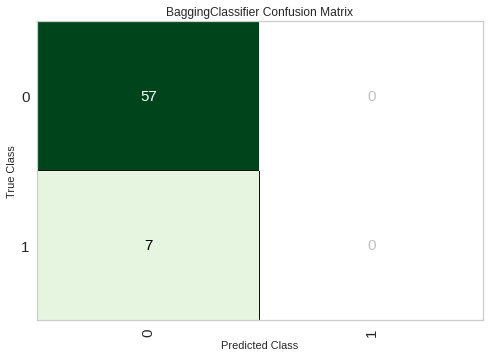

In [193]:
plot_model(lr_bagged, plot = 'confusion_matrix')

In [194]:
from pycaret.classification import predict_model

predictions = predict_model(lr_bagged)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,Bagging Classifier,0.8906,0.9398,0.0,0.0,0.0,0.0
